# Movie fMRI - Phase 1 QC (Quality Control)

Dataset: **500 Days of Summer (movie runs)**

In this notebook, our team:

- Loads movie BOLD runs for selected subjects.
- Checks each run's shape (x, y, z, t) and TR.
- Builds brain masks for each run and save them.
- Makes basic QC plots: mean EPI image, mask overlay, and one voxel time series.


In [ ]:
# Cell 2 - imports & base paths

from pathlib import Path
import numpy as np
import nibabel as nib
from nilearn import image, masking, plotting
import matplotlib.pyplot as plt
import os

DANIEL = "daniel"
KRANTHI = "kranthi"

user = DANIEL

if user == KRANTHI:
    # Base folders (adjust only if you move the project)
    DATA_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root\data")
    DERIV_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie")
    # Make sure derivatives folder exists

    DERIV_ROOT.mkdir(parents=True, exist_ok=True)

    print("DATA_ROOT exists:", DATA_ROOT.exists())
    print("Example contents in DATA_ROOT:", [p.name for p in DATA_ROOT.glob("*")][:10])
    print("DERIV_ROOT:", DERIV_ROOT)

# I had to move data/ and derivatives/ inside the Notebooks folder.
# Otherwise, I would have to prepend "..", which confuses Nibabel's gz reader.
if user == DANIEL:
    print(f"current directory: {os.getcwd()}")
    DATA_ROOT = Path("./data") # 
    DERIV_ROOT = Path("./derivatives/movie")
    print("DATA_ROOT exists:", DATA_ROOT.exists())
    print("Example contents in DATA_ROOT:", [p.name for p in DATA_ROOT.glob("*")][:10])
    print("DERIV_ROOT:", DERIV_ROOT)

current directory: c:\Users\User\Documents\FinalLap\Neural Data Science\FINAL_PROJECT\nds-movie-music-fmri\Notebooks
DATA_ROOT exists: True
Example contents in DATA_ROOT: ['sub-1_task-500daysofsummer_run-02_bold.nii.gz', 'sub-1_task-500daysofsummer_run-03_bold.nii.gz']
DERIV_ROOT: derivatives\movie


In [ ]:
# Cell 3 - find movie BOLD runs (run-02 only)

bold_files = sorted(
    DATA_ROOT.glob("**/sub-*task-500daysofsummer_run-02_bold.nii*")
)

print("Found BOLD runs (run-02):", len(bold_files))
for f in bold_files:
    print(" ", f)

if not bold_files:
    raise FileNotFoundError(
        "No BOLD files found for run-02. "
        "Check DATA_ROOT or that files are named "
        "sub-*_task-500daysofsummer_run-02_bold.nii"
    )


Found BOLD runs (run-02): 1
  data\sub-1_task-500daysofsummer_run-02_bold.nii.gz


## QC steps per subject (run-02 only)

For each subject's **500 Days of Summer - run-02** BOLD file, this notebook will:

- Load the 4D BOLD run.
- Print the image shape `(x, y, z, t)` and TR.
- Compute the mean image over time (`mean_img`) and an automatic brain mask (`mask_img`).
- Save the mask to `derivatives/movie/<sub-id>_run-02_mask.nii.gz`.
- Plot:
  - The mean EPI image.
  - The mask overlaid on the mean EPI.
  - One voxel time series from the center of the brain.


In [ ]:
# Cell 5 - helper function to run QC on one run-02 BOLD file

if user == DANIEL:
    print("hello, daniel")
    # %pip install simpleitk
    # import SimpleITK as sitk

def qc_one_run02(bold_path: Path, deriv_root: Path):
    """
    Run basic QC on a single movie BOLD run-02:
    - print shape and TR
    - compute mean image + mask
    - save mask
    - make QC plots
    - return a small summary dict
    """
    print("\n====================================")
    print("QC for:", bold_path)
    
    # if user == DANIEL:

    #     path_corrupted_nifti = bold_path
    #     sitk_img = sitk.ReadImage(path_corrupted_nifti)  # load with sitk
    #     sitk.WriteImage(sitk_img, path_corrupted_nifti)  # overwrite


    # Load image
    print(f"preparing to load image at path {bold_path}")
    img = image.load_img(bold_path)
    shape = img.shape                  # (x, y, z, t)
    zooms = img.header.get_zooms()     # (vx, vy, vz, TR)
    tr = float(zooms[3]) if len(zooms) > 3 else np.nan
    n_scans = int(shape[3])
    
    print("Shape (x, y, z, t):", shape)
    print("Voxel sizes:", zooms)
    print("TR (s):", tr)
    print("Number of scans (t):", n_scans)
    
    # Mean image and mask
    mean_img = image.mean_img(img)
    mask_img = masking.compute_epi_mask(img)
    
    # subject ID: "sub-XX"
    sub_id = bold_path.name.split("_")[0]
    
    # Save mask: derivatives/movie/<sub-id>_run-02_mask.nii.gz
    mask_name = f"{sub_id}_run-02_mask.nii.gz"
    mask_path = deriv_root / mask_name
    mask_img.to_filename(mask_path)
    print("Saved mask to:", mask_path)
    
    # --- QC plots ---
    # 1) Mean EPI
    plotting.plot_epi(mean_img, title=f"{sub_id} run-02 - mean EPI")
    
    # 2) Mask overlay
    plotting.plot_roi(
        mask_img, bg_img=mean_img,
        title=f"{sub_id} run-02 - brain mask"
    )
    
    # 3) One voxel time series (center voxel)
    data = img.get_fdata()
    x_c, y_c, z_c = shape[0] // 2, shape[1] // 2, shape[2] // 2
    ts = data[x_c, y_c, z_c, :]
    
    plt.figure()
    time_axis = np.arange(n_scans) * tr
    plt.plot(time_axis, ts)
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title(f"{sub_id} run-02 - center voxel time series")
    plt.tight_layout()
    plt.show()
    
    # Duration in minutes
    duration_min = (n_scans * tr) / 60.0
    
    return {
        "subject": sub_id,
        "run": "run-02",
        "n_scans": n_scans,
        "tr_s": tr,
        "duration_min": duration_min,
    }


hello, daniel




QC for: data\sub-1_task-500daysofsummer_run-02_bold.nii.gz
preparing to load image at path data\sub-1_task-500daysofsummer_run-02_bold.nii.gz
Shape (x, y, z, t): (64, 64, 40, 3307)
Voxel sizes: (3.203125, 3.203125, 3.2, 1.0)
TR (s): 1.0
Number of scans (t): 3307


C:\Users\User\AppData\Local\Temp\ipykernel_43180\1750755124.py:41: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_img = image.mean_img(img)


Saved mask to: derivatives\movie\sub-1_run-02_mask.nii.gz


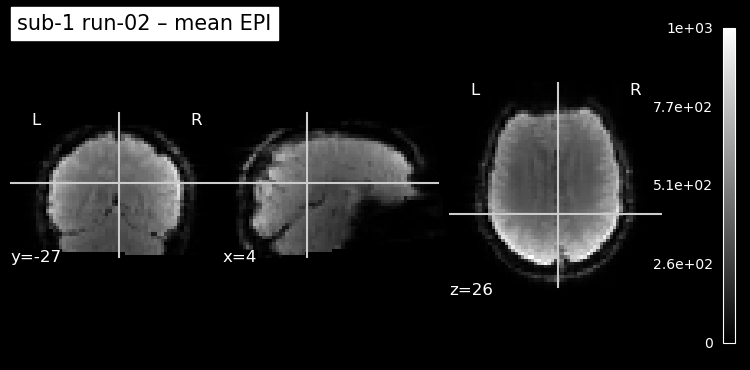

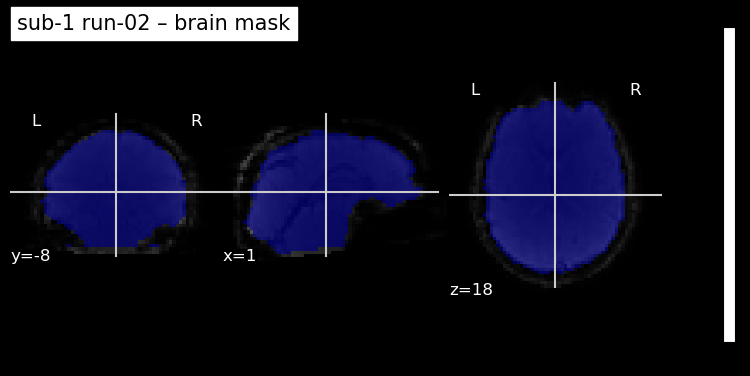

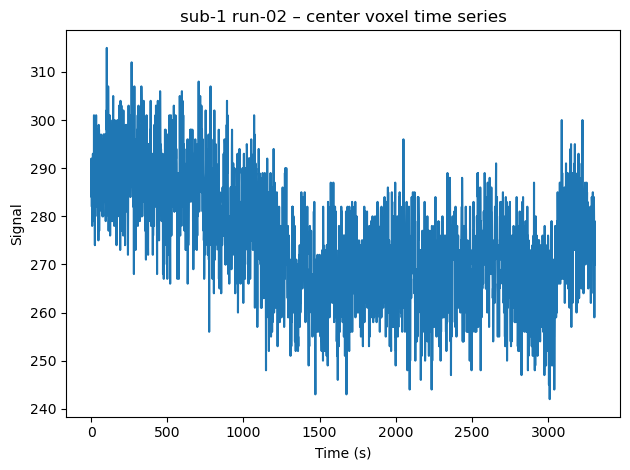


Finished QC for 1 run-02 files.


In [ ]:
# Cell 6 - run QC for all run-02 files and collect summaries

summary = []

for bold_path in bold_files:
    info = qc_one_run02(bold_path, DERIV_ROOT)
    summary.append(info)

print("\nFinished QC for", len(summary), "run-02 files.")


In [ ]:
# Cell 7 - summarize TR and number of scans per subject for run-02

import pandas as pd

summary_df = pd.DataFrame(summary).sort_values("subject")
display(summary_df)


,subject,run,n_scans,tr_s,duration_min
0,sub-12,run-02,2212,1.0,36.866667
1,sub-13,run-02,2208,1.0,36.800000
2,sub-14,run-02,2210,1.0,36.833333
3,sub-17,run-02,2212,1.0,36.866667
4,sub-18,run-02,2211,1.0,36.850000


## QC summary - run-02 (500 Days of Summer)

**Run duration & TR**

- All movie runs we used are *run-02* only, across 5 subjects (sub-12, sub-13, sub-14, sub-17, sub-18).
- Every run has TR = 1.0 s and about 2,210-2,212 time points.
- This corresponds to a run length of roughly **36.8 minutes** for each subject, so run-02 is a long, continuous chunk of the movie that we can treat as one naturalistic viewing segment.

**Mean EPI and masks**

- The mean EPI images show good whole-brain coverage with expected EPI contrast (gray/white matter structure is visible, no obvious cropping at the top of the brain).
- The automatically computed brain masks mostly follow the brain outline well and do not chop off large regions; the masks look slightly conservative near the very bottom of the brain (some inferior slices are darker), but overall they provide a reasonable in-brain region for later analysis.
- These checks suggest that using `compute_epi_mask` on run-02 is acceptable for our project, at least as a first-pass brain mask.

**Center-voxel time series**

- For all subjects, the center-voxel time series show realistic BOLD-like behavior: noisy fluctuations around a mean level, with occasional spikes and slow drifts over time.
- Sub-14 in particular shows a stronger slow trend and larger amplitude changes than the other subjects, which could reflect motion, physiological noise, or scanner drift; this is a subject we may want to watch more carefully in later preprocessing (e.g., motion regression and high-pass filtering).
- Importantly, none of the runs show obvious flat-line segments or catastrophic artifacts, so run-02 data appear usable.

**Conclusion**

Overall, the **run-02 movie data look consistent across subjects** in terms of TR, duration, coverage, and basic signal quality.  
The masks and time series are good enough to move on to the next analysis phase (modeling movie-driven activity and comparing across subjects), with a note that sub-14 may require a bit more attention for drift/motion in later steps.
